In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time

from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import uniform
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score

In [2]:
filipino_news_df = pd.read_csv('./Philippine_Fake_News_(Filipino Language).csv')

In [3]:
filipino_news_df.head()

,label,article
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...


In [4]:
filipino_news_df.describe()

,label
count,3206.000000
mean,0.500000
std,0.500078
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


#### Counts per Class

In [5]:
filipino_news_df['label'].value_counts()

label
0    1603
1    1603
Name: count, dtype: int64

#### Vocabulary Size

In [6]:
vectorizer = CountVectorizer()

# Fit and transform the 'text' column to get the document-term matrix
temp = vectorizer.fit_transform(filipino_news_df['article'])

# Get the vocabulary from the vectorizer
filipino_vocabulary = vectorizer.get_feature_names_out()

# Get the size of the vocabulary
filipino_vocabulary_size = len(filipino_vocabulary)
print("Vocabulary size:",filipino_vocabulary_size)

Vocabulary size: 39063


#### Splitting data into train and test data

In [7]:
X = filipino_news_df['article']
y = filipino_news_df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Count Vectorizer

##### Setting the parameter grid for tuning

In [8]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'classifier__alpha': np.arange(0.1,2.01,0.05)
}


##### Using the Whole Vocabulary

In [41]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=15,
    scoring='f1',
    n_jobs=8,
    cv=3,
    verbose=1,
    random_state=42
)

# Record the training time
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

# Calculate and store the training time
training_time_count_whole = end_time - start_time

# # Print the best parameters and best score
print("Best Parameters: ", random_search.best_params_)
print("Best F1 Score: {:.4f}".format(random_search.best_score_))

# Evaluate the model on the test set
test_f1_score = random_search.score(X_test, y_test)
print("Test F1: {:.4f}".format(test_f1_score))
print("Training time: {:.4f}".format(training_time_count_whole))

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Parameters:  {'vectorizer__ngram_range': (1, 2), 'classifier__alpha': 0.15000000000000002}
Best F1 Score: 0.9022
Test F1: 0.9078
Training time: 193.6130


##### Parameter Tuning

In [13]:
training_times_count_dataset1 = []

best_count_f1 = 0.0
best_count_max_features = None
best_count_ngram = None
best_count_alpha = None

for max_features in range(500,10001,1500):
    # print("Max features:", max_features)
    # Create a pipeline with CountVectorizer and Multinomial Naive Bayes
    pipeline = Pipeline([
        ('vectorizer', CountVectorizer(max_features=max_features)),
        ('classifier', MultinomialNB())
    ])

    # Initialize the RandomizedSearchCV
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=15,
        scoring='f1',
        n_jobs=8,
        cv=3,
        verbose=1,
        random_state=42
    )

    # Record the training time
    start_time = time.time()
    random_search.fit(X_train, y_train)
    end_time = time.time()

    # Calculate and store the training time
    training_time = end_time - start_time
    training_times_count_dataset1.append(training_time)

    # # Print the best parameters and best score
    # print("Best Parameters: ", random_search.best_params_)
    # print("Best F1 Score: {:.4f}".format(random_search.best_score_))

    # Evaluate the model on the test set
    test_f1_score = random_search.score(X_test, y_test)
    # print("Test F1: {:.4f}".format(test_f1_score))

    # Update the best test accuracy if the current iteration performs better
    if test_f1_score > best_count_f1:
        best_count_f1 = test_f1_score
        best_count_max_features = max_features
        best_count_ngram = random_search.best_params_['vectorizer__ngram_range']
        best_count_alpha = random_search.best_params_['classifier__alpha']

# Print the overall best test accuracy and corresponding parameters
print("\nOverall Best Test Accuracy:", best_count_f1)
print("Corresponding Best max_features:", best_count_max_features)
print("Corresponding Best alpha:", best_count_alpha)
print("Corresponding Best N-gram:", best_count_ngram)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Overall Best Test Accuracy: 0.9243421052631579
Corresponding Best max_features: 8000
Corresponding Best alpha: 0.40000000000000013
Corresponding Best N-gram: (1, 1)


In [16]:
training_times_count_dataset1

[12.781685829162598,
 10.842792749404907,
 11.4315505027771,
 11.024053573608398,
 11.030488014221191,
 11.05990481376648,
 12.645775318145752]

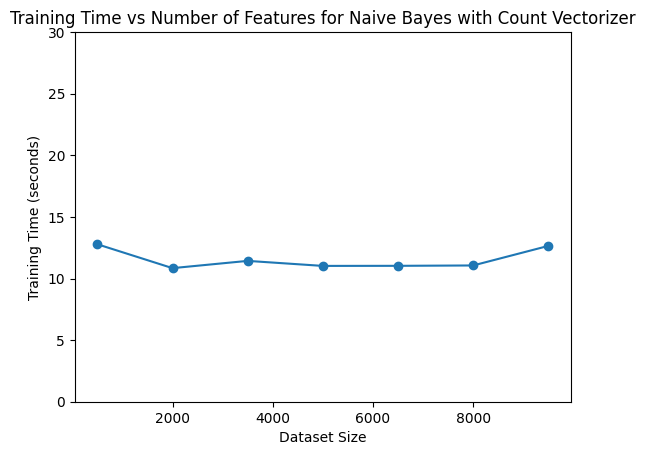

In [14]:
# Plot or analyze the training times against the dataset size
plt.plot(range(500,10001,1500), training_times_count_dataset1, marker='o')
plt.title('Training Time vs Number of Features for Naive Bayes with Count Vectorizer')
plt.xlabel('Dataset Size')
plt.ylabel('Training Time (seconds)')
plt.ylim(0, 30)
plt.show()

##### TF-IDF Vectorizer

##### Setting the parameter grid for tuning

In [17]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'classifier__alpha': np.arange(0.1,2.01,0.05)
}

##### Using the Whole Vocabulary

In [35]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=15,
    scoring='f1',
    n_jobs=8,
    cv=3,
    verbose=1,
    random_state=42
)

# Record the training time
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

# Calculate and store the training time
training_time_tfidf_whole = end_time - start_time

# # Print the best parameters and best score
print("Best Parameters: ", random_search.best_params_)
print("Best F1 Score: {:.4f}".format(random_search.best_score_))

# Evaluate the model on the test set
test_f1_score = random_search.score(X_test, y_test)
print("Test F1: {:.4f}".format(test_f1_score))
print("Training time: {:.4f}".format(training_time_tfidf_whole))

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Parameters:  {'vectorizer__ngram_range': (1, 1), 'classifier__alpha': 0.40000000000000013}
Best F1 Score: 0.7520
Test F1: 0.7958
Training time: 183.3082


##### Parameter Tuning

In [20]:
training_times_tfidf_dataset1 = []

best_tfidf_f1 = 0.0
best_tfidf_max_features = None
best_tfidf_ngram = None
best_tfidf_alpha = None

for max_features in range(500,10001,1500):
    # print("Max features:", max_features)
    # Create a pipeline with TF-IDF Vectorizer and Multinomial Naive Bayes
    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer(max_features=max_features)),
        ('classifier', MultinomialNB())
    ])

    # Initialize the RandomizedSearchCV
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=15,
        scoring='f1',
        n_jobs=8,
        cv=3,
        verbose=1,
        random_state=42
    )

    # Record the training time
    start_time = time.time()
    random_search.fit(X_train, y_train)
    end_time = time.time()

    # Calculate and store the training time
    training_time = end_time - start_time
    training_times_tfidf_dataset1.append(training_time)

    # # Print the best parameters and best score
    # print("Best Parameters: ", random_search.best_params_)
    # print("Best F1 Score: {:.4f}".format(random_search.best_score_))

    # Evaluate the model on the test set
    test_f1_score = random_search.score(X_test, y_test)
    # print("Test F1: {:.4f}".format(test_f1_score))

    # Update the best test accuracy if the current iteration performs better
    if test_f1_score > best_tfidf_f1:
        best_tfidf_f1 = test_f1_score
        best_tfidf_max_features = max_features
        best_tfidf_ngram = random_search.best_params_['vectorizer__ngram_range']
        best_tfidf_alpha = random_search.best_params_['classifier__alpha']

# Print the overall best test accuracy and corresponding parameters
print("\nOverall Best Test Accuracy:", best_tfidf_f1)
print("Corresponding Best max_features:", best_tfidf_max_features)
print("Corresponding Best alpha:", best_tfidf_alpha)
print("Corresponding Best N-gram:", best_tfidf_ngram)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Overall Best Test Accuracy: 0.9081632653061226
Corresponding Best max_features: 9500
Corresponding Best alpha: 0.15000000000000002
Corresponding Best N-gram: (1, 2)


In [21]:
training_times_tfidf_dataset1

[12.5738844871521,
 11.488173484802246,
 12.737465620040894,
 12.20629358291626,
 13.000053644180298,
 12.541595697402954,
 12.723864555358887]

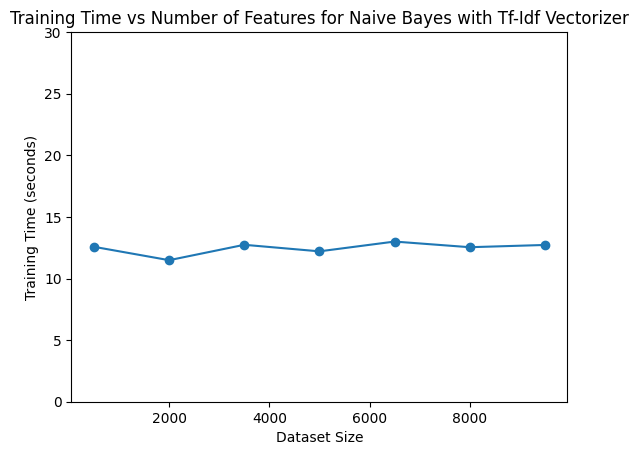

In [36]:
# Plot or analyze the training times against the dataset size
plt.plot(range(500,10001,1500), training_times_tfidf_dataset1, marker='o')
plt.title('Training Time vs Number of Features for Naive Bayes with Tf-Idf Vectorizer')
plt.xlabel('Dataset Size')
plt.ylabel('Training Time (seconds)')
plt.ylim(0, 30)
plt.show()

In [ ]:
best_count_vectorizer = CountVectorizer(max_features=best_count_max_features)

X_train_vectorized = best_count_vectorizer.fit_transform(X_train)

# Create a Multinomial Naive Bayes classifier with the best alpha
nb_classifier = MultinomialNB(alpha=best_count_alpha)

# Train the classifier on the vectorized training data
nb_classifier.fit(X_train_vectorized, y_train)

# Transform the test data using the same vectorizer
X_test_vectorized = best_count_vectorizer.transform(X_test)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test_vectorized)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

## Second Dataset

In [46]:
english_news_df = pd.read_csv('./Philippine_Fake_News_Corpus.csv')

In [47]:
english_news_df.head()

,Headline,Content,Authors,Date,URL,Brand,Label
0,PH ranks 2nd in Asia-Pacific in deaths due to ...,Pollution caused by traditional cooking fuel i...,['Philippine Daily Inquirer'],NaN,https://newsinfo.inquirer.net/987262/ph-ranks-...,Inquirer,Credible
1,"Aguirre, PCSO chief deny plotting to kill ‘Ato...",Justice Secretary Vitaliano Aguirre 2nd and Ph...,['Jomar Canlas'],2017-04-28 20:12:54+00:00,https://www.manilatimes.net/aguirre-pcso-chief...,Manila Times,Credible
2,Duterte says charges vs ex-President will fail,President Rodrigo Duterte on Monday night desc...,['Christine O. Avendaño'],NaN,https://newsinfo.inquirer.net/914727/duterte-s...,Inquirer,Credible
3,Group warns BFAR on law enforcement fund,THE militant fisher folk group Pambansang Laka...,['Neil Alcober'],2017-08-12 19:54:48+00:00,https://www.manilatimes.net/group-warns-bfar-l...,Manila Times,Credible
4,Solon asks Duterte for jet ski to Panatag,Magdalo Rep. Gary Alejano is willing to lead t...,['Dj Yap'],NaN,https://newsinfo.inquirer.net/882744/solon-ask...,Inquirer,Credible


In [48]:
english_news_df['Label'].value_counts()

Label
Credible        14802
Not Credible     7656
Name: count, dtype: int64

#### Vocabulary Size

In [49]:
vectorizer = CountVectorizer()

# Fit and transform the 'text' column to get the document-term matrix
temp = vectorizer.fit_transform(english_news_df['Content'])

# Get the vocabulary from the vectorizer
english_vocabulary = vectorizer.get_feature_names_out()

# Get the size of the vocabulary
english_vocabulary_size = len(english_vocabulary)
print("Vocabulary size:",english_vocabulary_size)

Vocabulary size: 119472


In [50]:
label_encoder = LabelEncoder()

# Encode the 'Label' column
english_news_df['Label'] = label_encoder.fit_transform(english_news_df['Label'])

# The mapping between original labels and encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'Credible': 0, 'Not Credible': 1}


In [51]:
X = english_news_df['Content']
y = english_news_df['Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Count Vectorizer

##### Setting the parameter grid for tuning

In [52]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'classifier__alpha': np.arange(0.1,2.01,0.05)
}


##### Using the Whole Vocabulary

In [53]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=15,
    scoring='f1',
    n_jobs=8,
    cv=3,
    verbose=1,
    random_state=42
)

# Record the training time
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

# Calculate and store the training time
training_time_count_whole2 = end_time - start_time

# # Print the best parameters and best score
print("Best Parameters: ", random_search.best_params_)
print("Best F1 Score: {:.4f}".format(random_search.best_score_))

# Evaluate the model on the test set
test_f1_score = random_search.score(X_test, y_test)
print("Test F1: {:.4f}".format(test_f1_score))
print("Training time: {:.4f}".format(training_time_count_whole2))

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Parameters:  {'vectorizer__ngram_range': (1, 2), 'classifier__alpha': 0.15000000000000002}
Best F1 Score: 0.9022
Test F1: 0.9078
Training time: 199.8194


##### Parameter Tuning

In [54]:
training_times_count_dataset2 = []

best_count_f1 = 0.0
best_count_max_features = None
best_count_ngram = None
best_count_alpha = None

for max_features in range(500,10001,1500):
    # print("Max features:", max_features)
    # Create a pipeline with CountVectorizer and Multinomial Naive Bayes
    pipeline = Pipeline([
        ('vectorizer', CountVectorizer(max_features=max_features)),
        ('classifier', MultinomialNB())
    ])

    # Initialize the RandomizedSearchCV
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=15,
        scoring='f1',
        n_jobs=8,
        cv=3,
        verbose=1,
        random_state=42
    )

    # Record the training time
    start_time = time.time()
    random_search.fit(X_train, y_train)
    end_time = time.time()

    # Calculate and store the training time
    training_time = end_time - start_time
    training_times_count_dataset2.append(training_time)

    # # Print the best parameters and best score
    # print("Best Parameters: ", random_search.best_params_)
    # print("Best F1 Score: {:.4f}".format(random_search.best_score_))

    # Evaluate the model on the test set
    test_f1_score = random_search.score(X_test, y_test)
    # print("Test F1: {:.4f}".format(test_f1_score))

    # Update the best test accuracy if the current iteration performs better
    if test_f1_score > best_count_f1:
        best_count_f1 = test_f1_score
        best_count_max_features = max_features
        best_count_ngram = random_search.best_params_['vectorizer__ngram_range']
        best_count_alpha = random_search.best_params_['classifier__alpha']

# Print the overall best test accuracy and corresponding parameters
print("\nOverall Best Test Accuracy:", best_count_f1)
print("Corresponding Best max_features:", best_count_max_features)
print("Corresponding Best alpha:", best_count_alpha)
print("Corresponding Best N-gram:", best_count_ngram)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Overall Best Test Accuracy: 0.8881206788183533
Corresponding Best max_features: 8000
Corresponding Best alpha: 0.8000000000000002
Corresponding Best N-gram: (2, 2)


In [55]:
training_times_count_dataset2

[186.99473977088928,
 187.45107173919678,
 184.22576689720154,
 190.4163055419922,
 186.54155158996582,
 188.2309546470642,
 187.86454677581787]

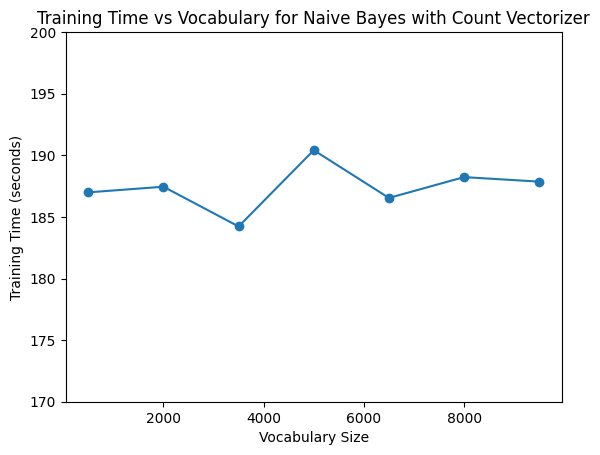

In [56]:
# Plot or analyze the training times against the dataset size
plt.plot(range(500,10001,1500), training_times_count_dataset2, marker='o')
plt.title('Training Time vs Vocabulary for Naive Bayes with Count Vectorizer')
plt.xlabel('Vocabulary Size')
plt.ylabel('Training Time (seconds)')
plt.ylim(170,200)
plt.show()

##### TF-IDF Vectorizer

##### Setting the parameter grid for tuning

In [57]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'classifier__alpha': np.arange(0.1,2.01,0.05)
}

##### Using the Whole Vocabulary

In [58]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=15,
    scoring='f1',
    n_jobs=8,
    cv=3,
    verbose=1,
    random_state=42
)

# Record the training time
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

# Calculate and store the training time
training_time_tfidf_whole2 = end_time - start_time

# # Print the best parameters and best score
print("Best Parameters: ", random_search.best_params_)
print("Best F1 Score: {:.4f}".format(random_search.best_score_))

# Evaluate the model on the test set
test_f1_score = random_search.score(X_test, y_test)
print("Test F1: {:.4f}".format(test_f1_score))
print("Training time: {:.4f}".format(training_time_tfidf_whole2))

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Parameters:  {'vectorizer__ngram_range': (1, 1), 'classifier__alpha': 0.40000000000000013}
Best F1 Score: 0.7520
Test F1: 0.7958
Training time: 189.4241


##### Parameter Tuning

In [59]:
training_times_tfidf_dataset2 = []

best_tfidf_f1 = 0.0
best_tfidf_max_features = None
best_tfidf_ngram = None
best_tfidf_alpha = None

for max_features in range(500,10001,1500):
    # print("Max features:", max_features)
    # Create a pipeline with TF-IDF Vectorizer and Multinomial Naive Bayes
    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer(max_features=max_features)),
        ('classifier', MultinomialNB())
    ])

    # Initialize the RandomizedSearchCV
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=15,
        scoring='f1',
        n_jobs=8,
        cv=3,
        verbose=1,
        random_state=42
    )

    # Record the training time
    start_time = time.time()
    random_search.fit(X_train, y_train)
    end_time = time.time()

    # Calculate and store the training time
    training_time = end_time - start_time
    training_times_tfidf_dataset2.append(training_time)

    # # Print the best parameters and best score
    # print("Best Parameters: ", random_search.best_params_)
    # print("Best F1 Score: {:.4f}".format(random_search.best_score_))

    # Evaluate the model on the test set
    test_f1_score = random_search.score(X_test, y_test)
    # print("Test F1: {:.4f}".format(test_f1_score))

    # Update the best test accuracy if the current iteration performs better
    if test_f1_score > best_tfidf_f1:
        best_tfidf_f1 = test_f1_score
        best_tfidf_max_features = max_features
        best_tfidf_ngram = random_search.best_params_['vectorizer__ngram_range']
        best_tfidf_alpha = random_search.best_params_['classifier__alpha']

# Print the overall best test accuracy and corresponding parameters
print("\nOverall Best Test Accuracy:", best_tfidf_f1)
print("Corresponding Best max_features:", best_tfidf_max_features)
print("Corresponding Best alpha:", best_tfidf_alpha)
print("Corresponding Best N-gram:", best_tfidf_ngram)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Overall Best Test Accuracy: 0.8859278518037049
Corresponding Best max_features: 8000
Corresponding Best alpha: 0.25000000000000006
Corresponding Best N-gram: (2, 2)


In [60]:
training_times_tfidf_dataset2

[183.5131015777588,
 184.51188325881958,
 183.79959797859192,
 198.44182348251343,
 186.58185362815857,
 188.74014806747437,
 184.56705617904663]

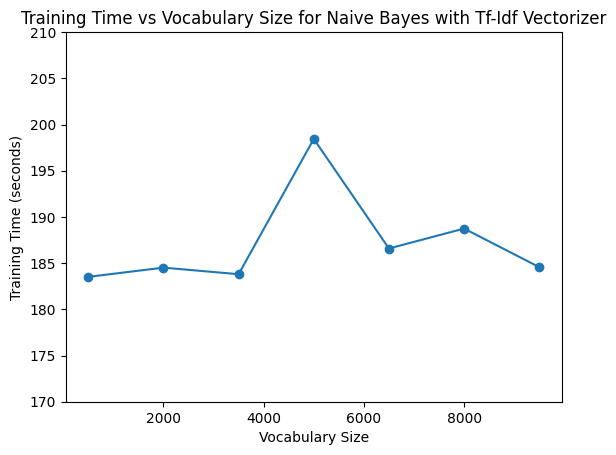

In [63]:
# Plot or analyze the training times against the dataset size
plt.plot(range(500,10001,1500), training_times_tfidf_dataset2, marker='o')
plt.title('Training Time vs Vocabulary Size for Naive Bayes with Tf-Idf Vectorizer')
plt.xlabel('Vocabulary Size')
plt.ylabel('Training Time (seconds)')
plt.ylim(170,210)
plt.show()